<a href="https://colab.research.google.com/github/jonathansuarezpadilla/Factorial/blob/main/PBR_multiples_reacciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Reactor PBR con múltiples reacciones**
SO$_2$ + 1/2O$_2$ → SO$_3$    (1)\
2SO$_2$ + 2H$_2$O → 2H$_2$SO$_4$  (2) reacción no deseada \
N$_2$ + O$_2$ → 2NO  (3) reacción no deseada

## **REVISAR**

  Verificación - Conversión: 0.956858, Yield total: 0.956858
RESULTADOS DEL REACTOR PBR - TRES REACCIONES
Condiciones de entrada:
  F_A(SO2)_in: 0.002980 kmol/s
  F_B(O2)_in: 0.005535 kmol/s
  F_F(N2)_in: 0.033634 kmol/s
  F_D(H2O)_in: 0.000426 kmol/s
  F_total_in: 0.042575 kmol/s
  Presión: 5.50 atm
  Temperatura: 707.9 K

Resultados en conversión objetivo (95.0%):
  W requerido: 0.28 kg
  V requerido: 0.0011 m³
  Longitud del reactor: 0.01 m
  Presión: 5.5000 atm
  Conversión alcanzada: 0.9569

Flujos molares a W_obj (kmol/s):
  F_A(SO2): 0.000129
  F_C(SO3): 0.002426
  F_B(O2): 0.004109
  F_F(N2): 0.033634
  F_G(NO): 0.000000
  F_D(H2O): 0.000000
  F_E(H2SO4): 0.000426
  Flujo total: 0.040723

Selectividades a W_obj:
  Selectividad H2SO4/SO2: 0.149274
  Selectividad NO/SO2: 0.000000

Yields (Rendimientos) a W_obj:
  Yield SO3/SO2: 0.814024 (81.40%)
  Yield H2SO4/SO2: 0.142834 (14.28%)
  Yield NO/SO2: 0.000000 (0.00%)
  Yield total: 0.956858 (95.69%)


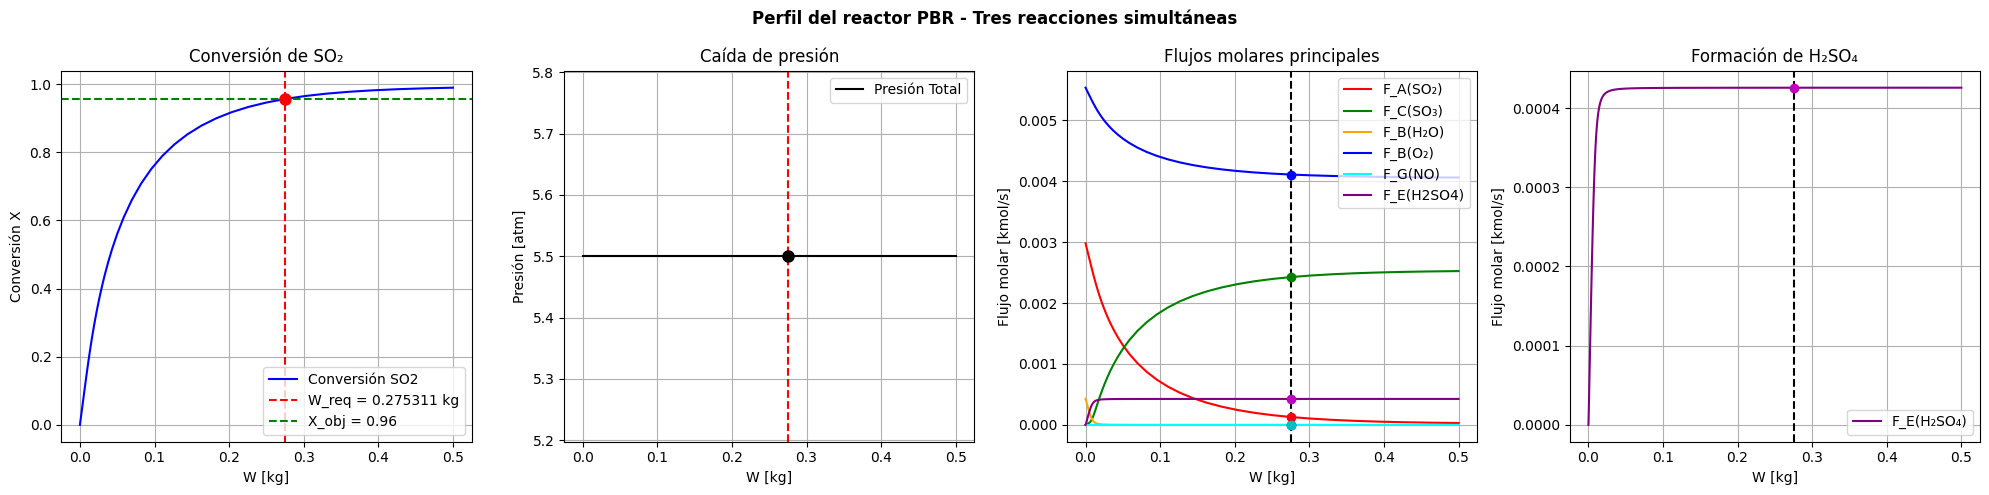

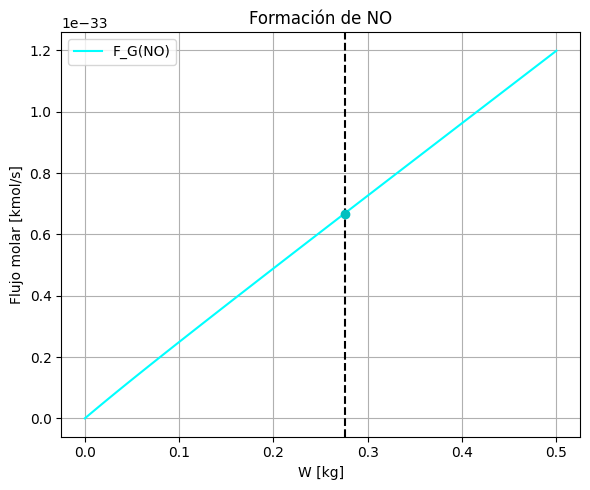

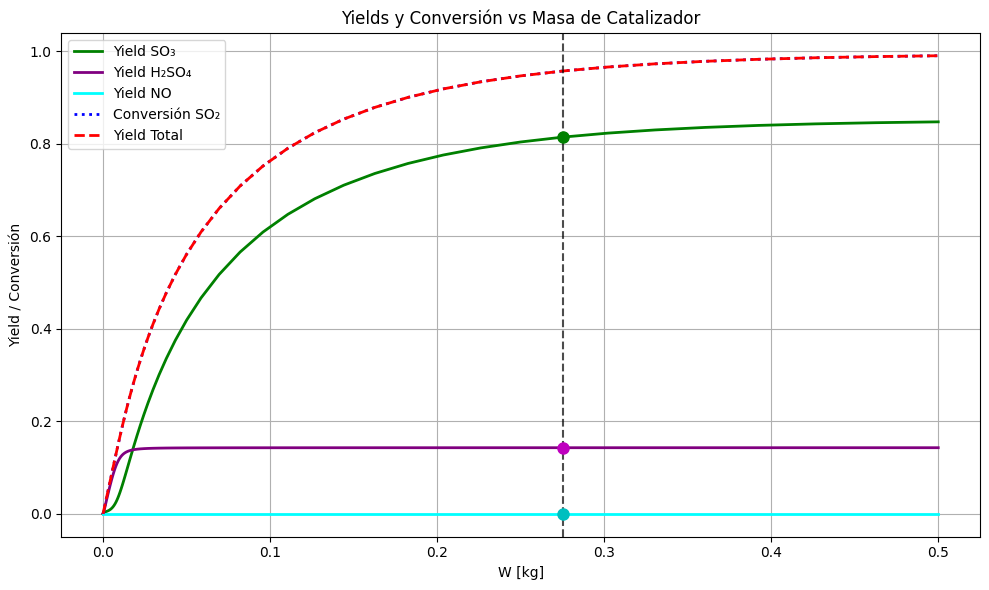

In [ ]:
# Ingenieria de los reactores quimicos
# 2025-2S
# Equipo 4
# Reactor PBR multiples reacciones

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# === Parámetros de entrada ===
produccion_deseada = 19584   # kg/día
PM_SO3 = 80.06  # kg/kmol
T = 707.9  # K
P0_atm = 5.5  # atm
R = 0.082057  # atm·m³/kmol·K

# Geometría y catalizador
rho_b = 256  # [kg/m³] densidad del lecho
D_reactor = 0.31 # [m]
Ac = np.pi * (D_reactor / 2) ** 2  # [m²]
dp = 0.005961  # diametro de particula [m]
phi = 0.303 # porosidad del lecho
mu = 3.43e-5  # [Pa·s] viscosidad del flujo de gas de alimentación
include_pressure_drop = False
conversion_objetivo = 0.95

# Composición de la alimentación (fracciones molares)
y_A_feed = 0.07   # SO2
y_B_feed = 0.13   # O2
y_F_feed = 0.79   # N2
y_D_feed = 0.01   # H2O

# === Cinética (mantengo tus expresiones) ===
Kp = np.exp((11300 / T) - 10.68)
k1 = np.exp(12.16 - (5473 / T))
K2 = np.exp(-9.953 + (8619 / T))
K3 = np.exp(-71.745 + (52596 / T))

# === Constante para reacción 2 ===
k_l_molecules = 2.26e-43 * T * np.exp(6544 / T)  # cm³/(molécula²·s)

# Número de Avogadro
N_avogadro = 6.02214076e23  # moléculas/mol

# === Flujos molares (inlet) ===
produccion_kmol_dia = produccion_deseada / PM_SO3  # [kmol/dia]
F_C_produccion = produccion_kmol_dia / (24 * 3600)  # [kmol/s]
F_A_in = F_C_produccion / conversion_objetivo  # [kmol/s] (entrada de SO2 que sería convertida)
F_total_in = F_A_in / y_A_feed
F_B_in = F_total_in * y_B_feed
F_F_in = F_total_in * y_F_feed
F_C_in = 0.0  # No hay SO3 a la entrada
F_G_in = 0.0  # No hay NO a la entrada
F_D_in = F_total_in * y_D_feed  # el aire no es 100% seco, se considdera una parte de humedad
F_E_in = 0.0  # No hay H2SO4 a la entrada

# Flujo Volumétrico in
F_vol = F_total_in * R * T / P0_atm  # [m3/s]
C_A_in = F_A_in / F_vol if F_vol > 0 else 0.0
theta_b = F_B_in / F_A_in if F_A_in > 0 else 0.0

# Masa molar species (kg/kmol)
M_A, M_B, M_C, M_D, M_E, M_F, M_G = 64.06, 32.00, 80.06, 18.02, 98.08, 28.013, 30.01

# REACCION FORMACION DE NOx - CORREGIDO
def calcular_tasa_NO(T, P_B, P_F, P_G, rho_b):
    """
    Calcula la tasa de formación de NO en kmol/(kg_cat·s)

    Parámetros:
    T: Temperatura (K)
    P_B, P_F, P_G: Presiones parciales (atm) de O2, N2, NO
    rho_b: Densidad del lecho (kg/m³)

    Retorna:
    r_3: Tasa de formación de NO (kmol/(kg_cat·s))
    """
    # Convertir presiones parciales a concentraciones (mol/m³)
    R_m3 = 8.314  # J/mol·K = Pa·m³/mol·K
    P_Pa = 101325  # 1 atm en Pa

    # Concentraciones en mol/m³
    C_B = (P_B * P_Pa) / (R_m3 * T)
    C_F = (P_F * P_Pa) / (R_m3 * T)
    C_G = (P_G * P_Pa) / (R_m3 * T)

    # Constantes de velocidad (ANSYS, 2009)
    kf1 = 1.8e8 * np.exp(-38370 / T)    # m³/mol·s
    kf2 = 1.8e4 * np.exp(-4680 / T)     # m³/mol·s
    kr1 = 3.8e7 * np.exp(-425 / T)      # m³/mol·s
    kr2 = 3.81e4 * np.exp(-20820 / T)   # m³/mol·s
    kO = 3.81e5 * (T ** -0.5) * np.exp(-31090 / T)  # mol⁰·⁵/m¹·⁵·s

    # Evitar divisiones por cero
    C_B = max(C_B, 1e-20)
    C_F = max(C_F, 1e-20)
    C_G = max(C_G, 1e-20)

    # Tasa en mol/m³·s
    numerador = 1 - (kr1 * kr2 * C_G**2) / (kf1 * C_F * kf2 * C_B)
    denominador = 1 + (kr1 * C_G) / (kf2 * C_B)

    r_3_mol_m3s = 2 * kf1 * kO * (C_B ** 0.5) * C_F * (numerador / denominador)

    # Convertir a kmol/(kg_cat·s)
    r_3 = r_3_mol_m3s / (rho_b * 1000.0)

    return r_3

def calcular_tasa_reaccion_2(T, C_C, C_D, rho_b):
    """
    Calcula la tasa de la reacción 2: C(SO3) + D(H2O) → E(H2SO4)
    en kmol/(kg_cat·s)

    Parámetros:
    T: Temperatura (K)
    C_C, C_D: Concentraciones de SO3 y H2O (mol/m³)
    rho_b: Densidad del lecho (kg/m³)

    Retorna:
    r_2: Tasa de reacción (kmol/(kg_cat·s))
    """
    # Convertir concentraciones de mol/m³ a moléculas/cm³
    # 1 mol/m³ = (N_avogadro moléculas/mol) / (1e6 cm³/m³) = N_avogadro/1e6 moléculas/cm³
    factor_conversion = N_avogadro / 1e6

    C_C_moleculas = C_C * factor_conversion  # moléculas/cm³
    C_D_moleculas = C_D * factor_conversion  # moléculas/cm³

    # Constante cinética en moléculas/cm³·s
    k_l_molecules = 2.26e-43 * T * np.exp(6544 / T)  # cm³/(molécula²·s)

    # Tasa en moléculas/(cm³·s)
    r_2_molecules = k_l_molecules * C_C_moleculas * (C_D_moleculas ** 2)

    # Convertir a kmol/(m³·s)
    # 1 molécula/(cm³·s) = (1/N_avogadro) mol/(cm³·s) × 1000 mol/kmol × 1e6 cm³/m³
    # = (1000 × 1e6 / N_avogadro) kmol/(m³·s)
    factor_conversion_2 = 1000 * 1e6 / N_avogadro
    r_2_kmol_m3s = r_2_molecules * factor_conversion_2

    # Convertir a kmol/(kg_cat·s)
    r_2 = r_2_kmol_m3s / rho_b

    return r_2

# === Ecuaciones diferenciales usando balances por especie ===
# Estados: [F_A, F_C, F_B, F_G, F_F, F_D, F_E, P] (F_i en kmol/s, P en atm)
def pbr_ode(W, Y):
    # === Variables de estado ===
    F_A, F_C, F_B, F_G, F_F, F_D, F_E, P = Y
    if P <= 1e-9:
        P = 1e-9

    # Flujo total
    FT = F_A + F_C + F_B + F_G + F_F + F_D + F_E
    if FT <= 0:
        FT = 1e-12

    # Presiones parciales (atm)
    p_A = P * max(F_A, 0.0) / FT
    p_C = P * max(F_C, 0.0) / FT
    p_B = P * max(F_B, 0.0) / FT
    p_G = P * max(F_G, 1e-20) / FT
    p_F = P * max(F_F, 1e-20) / FT
    p_D = P * max(F_D, 1e-20) / FT
    p_E = P * max(F_E, 1e-20) / FT

    # === Reacción principal: r1: A(SO₂) + 1/2 B(O₂) → C(SO₃) ===
    if p_A > 0 and p_B > 0:
        beta = p_C / (Kp * p_A * np.sqrt(max(p_B, 1e-12)))
    else:
        beta = 0.0
    term_rev = max(0.0, 1.0 - beta)

    numer = k1 * p_B * p_A * term_rev
    denom = 22.414 * (1.0 + K2 * p_A + K3 * p_C) ** 2
    r_1 = numer / denom  # kmol/(kg·s) de formación de SO₃ por kg de catalizador

    # === Reacción 2: C(SO₃) + D(H₂O) → E(H₂SO₄) ===
    # Convertir presiones parciales a concentraciones (mol/m³)
    R_m3 = 8.314  # J/mol·K
    P_Pa = 101325  # 1 atm en Pa

    C_C = (p_C * P_Pa) / (R_m3 * T)  # mol/m³
    C_D = (p_D * P_Pa) / (R_m3 * T)  # mol/m³

    r_2 = calcular_tasa_reaccion_2(T, C_C, C_D, rho_b)  # kmol/(kg_cat·s)

    # === Reacción 3: F(N₂) + B(O₂) → 2G(NO) ===
    r_3 = calcular_tasa_NO(T, p_B, p_F, p_G, rho_b)  # kmol/(kg_cat·s)

    # === BALANCES MOLARES ===
    # Reacción 1: A + 1/2 B → C
    # Reacción 2: C + D → E
    # Reacción 3: F + B → 2G

    dF_A_dW = -r_1                    # A consumido en reacción 1
    dF_C_dW = +r_1 - r_2              # C producido en reacción 1, consumido en reacción 2
    dF_B_dW = -0.5 * r_1 - r_3        # B consumido en reacciones 1 y 3
    dF_G_dW = +2 * r_3                # G producido en reacción 3
    dF_F_dW = -r_3                    # F consumido en reacción 3
    dF_D_dW = -r_2                    # D consumido en reacción 2
    dF_E_dW = +r_2                    # E producido en reacción 2

    # === Caída de presión (Ergun) ===
    if include_pressure_drop:
        # Flujo volumétrico (m³/s)
        v = FT * R * T / max(P, 1e-12)
        u = v / Ac  # velocidad superficial (m/s)

        # Densidad de mezcla (kg/m³)
        M_mix = (F_A * M_A + F_C * M_C + F_B * M_B + F_G * M_G + F_F * M_F + F_D * M_D + F_E * M_E) / FT
        rho_g = (P * M_mix) / (R * T)  # R en atm·m³/kmol·K

        term1 = (150.0 * (1.0 - phi) ** 2 * mu * u) / (phi ** 3 * dp ** 2)
        term2 = (1.75 * (1.0 - phi) * rho_g * u ** 2) / (phi ** 3 * dp)
        dPdz_Pa = - (term1 + term2)
        dPdz_atm = dPdz_Pa / 101325.0
        dPdW = dPdz_atm / (rho_b * Ac)
    else:
        dPdW = 0.0

    return [dF_A_dW, dF_C_dW, dF_B_dW, dF_G_dW, dF_F_dW, dF_D_dW, dF_E_dW, dPdW]

# === Solución del ODE ===
W_span = (0.0, 0.5)  # kg catalizador
y0 = [F_A_in, F_C_in, F_B_in, F_G_in, F_F_in, F_D_in, F_E_in, P0_atm]
sol = solve_ivp(pbr_ode, W_span, y0, method='RK45', rtol=1e-7, atol=1e-10, dense_output=True)
W = sol.t
F_A = sol.y[0]
F_C = sol.y[1]
F_B = sol.y[2]
F_G = sol.y[3]
F_F = sol.y[4]
F_D = sol.y[5]
F_E = sol.y[6]
P = sol.y[7]

# === Cálculo de FT y conversión ===
FT = F_A + F_C + F_B + F_G + F_F + F_D + F_E
# Conversión de SO2 con respecto a la entrada
X = 1.0 - F_A / F_A_in

# === Calcular presiones parciales ===
p_A = P * F_A / FT
p_C = P * F_C / FT
p_B = P * F_B / FT
p_F = P * F_F / FT
p_G = P * F_G / FT
p_D = P * F_D / FT
p_E = P * F_E / FT

# === Encontrar W requerido para la conversión objetivo ===
reached_idx = np.where(X >= conversion_objetivo)[0]
if reached_idx.size == 0:
    print("No se alcanzó conversión objetivo en W_span.")
    W_req = np.nan
    V_req = np.nan
    P_obj = P[-1]
    X_obj = X[-1]
    FT_obj = FT[-1]
    p_A_obj = p_A[-1]
    p_C_obj = p_C[-1]
    p_B_obj = p_B[-1]
    p_F_obj = p_F[-1]
    p_G_obj = p_G[-1]
    p_D_obj = p_D[-1]
    p_E_obj = p_E[-1]
    F_A_obj = F_A[-1]
    F_C_obj = F_C[-1]
    F_B_obj = F_B[-1]
    F_F_obj = F_F[-1]
    F_G_obj = F_G[-1]
    F_D_obj = F_D[-1]
    F_E_obj = F_E[-1]
    idx = -1
else:
    idx = reached_idx[0]
    W_req = W[idx]
    V_req = W_req / rho_b
    P_obj = P[idx]
    X_obj = X[idx]
    FT_obj = FT[idx]
    p_A_obj = p_A[idx]
    p_C_obj = p_C[idx]
    p_B_obj = p_B[idx]
    p_F_obj = p_F[idx]
    p_G_obj = p_G[idx]
    p_D_obj = p_D[idx]
    p_E_obj = p_E[idx]
    F_A_obj = F_A[idx]
    F_C_obj = F_C[idx]
    F_B_obj = F_B[idx]
    F_F_obj = F_F[idx]
    F_G_obj = F_G[idx]
    F_D_obj = F_D[idx]
    F_E_obj = F_E[idx]

# Calcular yields en todo el rango de W (después de la solución ODE)
yield_SO3_array = F_C / F_A_in
yield_H2SO4_array = F_E / F_A_in
yield_NO_array = F_G / F_A_in
yield_total_array = yield_SO3_array + yield_H2SO4_array + yield_NO_array
# === Calcular Yields (Rendimientos) ===
# Yield de SO3 (C) con respecto a SO2 alimentado
yield_SO3 = F_C_obj / F_A_in

# Yield de H2SO4 (E) con respecto a SO2 alimentado
yield_H2SO4 = F_E_obj / F_A_in

# Yield de NO (G) con respecto a SO2 alimentado
yield_NO = F_G_obj / F_A_in

# Yield total (suma de todos los productos basados en SO2)
yield_total = yield_SO3 + yield_H2SO4 + yield_NO

# Calculate selectivities
# SO2 reacted
F_A_reacted = F_A_in - F_A_obj

# Selectivity H2SO4 relative to reacted SO2
if F_A_reacted > 1e-9: # Avoid division by zero or near zero
    selectividad_H2SO4 = F_E_obj / F_A_reacted
else:
    selectividad_H2SO4 = 0.0

# Selectivity NO relative to reacted SO2
if F_A_reacted > 1e-9: # Avoid division by zero or near zero
    selectividad_NO = F_G_obj / F_A_reacted
else:
    selectividad_NO = 0.0


# Verificación: Yield total debería ser igual a la conversión
print(f"  Verificación - Conversión: {X_obj:.6f}, Yield total: {yield_total:.6f}")

# === Mostrar resultados ===
print("=" * 60)
print("RESULTADOS DEL REACTOR PBR - TRES REACCIONES")
print("=" * 60)
print(f"Condiciones de entrada:")
print(f"  F_A(SO2)_in: {F_A_in:.6f} kmol/s")
print(f"  F_B(O2)_in: {F_B_in:.6f} kmol/s")
print(f"  F_F(N2)_in: {F_F_in:.6f} kmol/s")
print(f"  F_D(H2O)_in: {F_D_in:.6f} kmol/s")
print(f"  F_total_in: {F_total_in:.6f} kmol/s")
print(f"  Presión: {P0_atm:.2f} atm")
print(f"  Temperatura: {T:.1f} K")

if not np.isnan(W_req):
    print(f"\nResultados en conversión objetivo ({conversion_objetivo*100:.1f}%):")
    print(f"  W requerido: {W_req:.2f} kg")
    print(f"  V requerido: {V_req:.4f} m³")
    print(f"  Longitud del reactor: {V_req/Ac:.2f} m")
    print(f"  Presión: {P_obj:.4f} atm")
    print(f"  Conversión alcanzada: {X_obj:.4f}")
    print(f"\nFlujos molares a W_obj (kmol/s):")
    print(f"  F_A(SO2): {F_A_obj:.6f}")
    print(f"  F_C(SO3): {F_C_obj:.6f}")
    print(f"  F_B(O2): {F_B_obj:.6f}")
    print(f"  F_F(N2): {F_F_obj:.6f}")
    print(f"  F_G(NO): {F_G_obj:.6f}")
    print(f"  F_D(H2O): {F_D_obj:.6f}")
    print(f"  F_E(H2SO4): {F_E_obj:.6f}")
    print(f"  Flujo total: {FT_obj:.6f}")

    print(f"\nSelectividades a W_obj:")
    print(f"  Selectividad H2SO4/SO2: {selectividad_H2SO4:.6f}")
    print(f"  Selectividad NO/SO2: {selectividad_NO:.6f}")

else:
    print(f"\nNo se alcanzó la conversión objetivo. Últimos valores:")
    print(f"  W máximo: {W[-1]:.2f} kg")
    print(f"  Conversión máxima: {X[-1]:.4f}")

print(f"\nYields (Rendimientos) a W_obj:")
print(f"  Yield SO3/SO2: {yield_SO3:.6f} ({yield_SO3*100:.2f}%)")
print(f"  Yield H2SO4/SO2: {yield_H2SO4:.6f} ({yield_H2SO4*100:.2f}%)")
print(f"  Yield NO/SO2: {yield_NO:.6f} ({yield_NO*100:.2f}%)")
print(f"  Yield total: {yield_total:.6f} ({yield_total*100:.2f}%)")

# === Graficar ===
plt.figure(figsize=(20, 5))

# Conversión vs W
plt.subplot(1, 4, 1)
plt.plot(W, X, label='Conversión SO2', color="blue")
if not np.isnan(W_req):
    plt.axvline(W_req, linestyle='--', color='r', label=f'W_req = {W_req:.6f} kg')
    plt.axhline(X_obj, linestyle='--', color='g', label=f'X_obj = {X_obj:.2f}')
    plt.plot(W_req, X_obj, 'ro', markersize=8)
plt.xlabel('W [kg]')
plt.ylabel('Conversión X')
plt.title('Conversión de SO₂')
plt.grid()
plt.legend()

# Presión vs W
plt.subplot(1, 4, 2)
plt.plot(W, P, label='Presión Total', color="black")
if not np.isnan(W_req):
    plt.axvline(W_req, linestyle='--', color='r')
    plt.plot(W_req, P_obj, 'ko', markersize=8)
plt.xlabel('W [kg]')
plt.ylabel('Presión [atm]')
plt.title('Caída de presión')
plt.grid()
plt.legend()

# Flujos molares principales vs W
plt.subplot(1, 4, 3)
plt.plot(W, F_A, label='F_A(SO₂)', color='red')
plt.plot(W, F_C, label='F_C(SO₃)', color='green')
plt.plot(W, F_D, label='F_B(H₂O)', color='orange')
plt.plot(W, F_B, label='F_B(O₂)', color='blue')
plt.plot(W, F_G, label='F_G(NO)', color='cyan')
plt.plot(W, F_E, label='F_E(H2SO4)', color='purple')
#plt.plot(W, F_F, label='F_F(N₂)', color='orange')

if not np.isnan(W_req):
    plt.axvline(W_req, linestyle='--', color='k')
    plt.plot(W_req, F_A[idx], 'ro', markersize=6)
    plt.plot(W_req, F_C[idx], 'go', markersize=6)
    plt.plot(W_req, F_D[idx], 'bo', markersize=6)
    plt.plot(W_req, F_B[idx], 'bo', markersize=6)
    plt.plot(W_req, F_G[idx], 'co', markersize=6)
    plt.plot(W_req, F_E[idx], 'mo', markersize=6)
    #plt.plot(W_req, F_F[idx], 'yo', markersize=6)


plt.xlabel('W [kg]')
plt.ylabel('Flujo molar [kmol/s]')
plt.title('Flujos molares principales')
plt.grid()
plt.legend()

# Flujo molar de H2SO4 (E) vs W
plt.subplot(1, 4, 4)
plt.plot(W, F_E, label='F_E(H₂SO₄)', color='purple')

if not np.isnan(W_req):
    plt.axvline(W_req, linestyle='--', color='k')
    plt.plot(W_req, F_E[idx], 'mo', markersize=6)

plt.xlabel('W [kg]')
plt.ylabel('Flujo molar [kmol/s]')
plt.title('Formación de H₂SO₄')
plt.grid()
plt.legend()

plt.suptitle('Perfil del reactor PBR - Tres reacciones simultáneas', fontweight='bold')
plt.tight_layout()
plt.show()

# Nuevo plot para F_G (NO) vs W
plt.figure(figsize=(6, 5))
plt.plot(W, F_G, label='F_G(NO)', color='cyan')

if not np.isnan(W_req):
    plt.axvline(W_req, linestyle='--', color='k')
    plt.plot(W_req, F_G[idx], 'co', markersize=6)

plt.xlabel('W [kg]')
plt.ylabel('Flujo molar [kmol/s]')
plt.title('Formación de NO')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Gráfica de Yields vs W
plt.figure(figsize=(10, 6))
plt.plot(W, yield_SO3_array, label='Yield SO₃', color='green', linewidth=2)
plt.plot(W, yield_H2SO4_array, label='Yield H₂SO₄', color='purple', linewidth=2)
plt.plot(W, yield_NO_array, label='Yield NO', color='cyan', linewidth=2)
plt.plot(W, X, label='Conversión SO₂', color='blue', linestyle=':',linewidth=2)
plt.plot(W, yield_total_array, label='Yield Total', color='red', linestyle='--', linewidth=2)

if not np.isnan(W_req):
    plt.axvline(W_req, linestyle='--', color='k', alpha=0.7)
    plt.plot(W_req, yield_SO3_array[idx], 'go', markersize=8)
    plt.plot(W_req, yield_H2SO4_array[idx], 'mo', markersize=8)
    plt.plot(W_req, yield_NO_array[idx], 'co', markersize=8)

plt.xlabel('W [kg]')
plt.ylabel('Yield / Conversión')
plt.title('Yields y Conversión vs Masa de Catalizador')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

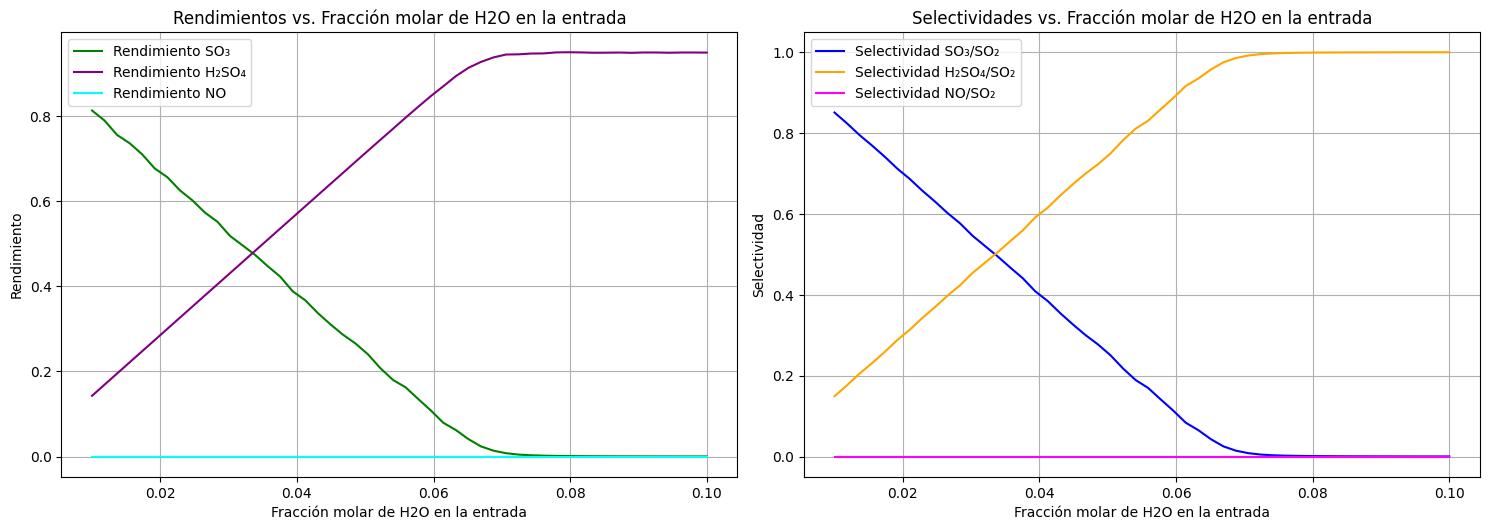


--- Análisis de rendimiento y selectividad ---
El rendimiento de H₂SO₄ supera al de SO₃ a partir de una fracción molar de H₂O en la entrada de aproximadamente: 0.0339
La selectividad de H₂SO₄ supera a la de SO₃ a partir de una fracción molar de H₂O en la entrada de aproximadamente: 0.0339


In [ ]:
# ¿Cómo afecta la fracción molar de H2O en el flujo de entrada?

h2o_molar_fractions = np.linspace(0.01, 0.1, 50) # Fracciones molares de H2O a la entrada
w_req_list = []
x_obj_list = []
yield_so3_list = []
yield_h2so4_list = []
yield_no_list = []
selectivity_so3_list = []
selectivity_h2so4_list = []
selectivity_no_list = []

# Calculate constant inlet flows outside the loop
produccion_kmol_dia = produccion_deseada / PM_SO3
F_C_produccion = produccion_kmol_dia / (24 * 3600)
F_A_in_const = F_C_produccion / conversion_objetivo
F_total_in_const = F_A_in_const / y_A_feed
F_B_in_const = F_total_in_const * y_B_feed
F_F_in_const = F_total_in_const * y_F_feed
F_C_in_const = 0.0
F_G_in_const = 0.0
F_E_in_const = 0.0

for y_D_feed in h2o_molar_fractions:
    # Recalculate only the H2O inlet flow within the loop
    F_D_in = F_total_in_const * y_D_feed

    # Define initial conditions
    y0 = [F_A_in_const, F_C_in_const, F_B_in_const, F_G_in_const, F_F_in_const, F_D_in, F_E_in_const, P0_atm]

    # Solve the ODE without dense_output
    sol = solve_ivp(pbr_ode, W_span, y0, method='RK45', rtol=1e-7, atol=1e-10) # Removed dense_output=True
    W = sol.t
    F_A = sol.y[0]
    F_C = sol.y[1]
    F_B = sol.y[2]
    F_G = sol.y[3]
    F_F = sol.y[4]
    F_D = sol.y[5]
    F_E = sol.y[6]
    P = sol.y[7]

    # Calculate conversion over the whole range of W
    # Need to use F_A_in_const here as it's the initial feed
    X = 1.0 - F_A / F_A_in_const

    # Find W_req and extract results at objective conversion or end of simulation
    reached_idx = np.where(X >= conversion_objetivo)[0]
    if reached_idx.size == 0:
        W_req = np.nan
        X_obj = X[-1]
        F_A_obj = F_A[-1]
        F_C_obj = F_C[-1]
        F_E_obj = F_E[-1]
        F_G_obj = F_G[-1]
    else:
        idx = reached_idx[0]
        W_req = W[idx]
        X_obj = X[idx]
        F_A_obj = F_A[idx]
        F_C_obj = F_C[idx]
        F_E_obj = F_E[idx]
        F_G_obj = F_G[idx]

    # Calculate yields at W_obj (using F_A_in_const for the denominator)
    yield_SO3 = F_C_obj / F_A_in_const
    yield_H2SO4 = F_E_obj / F_A_in_const
    yield_NO = F_G_obj / F_A_in_const

    # Calculate selectivities at W_obj
    F_A_reacted = F_A_in_const - F_A_obj
    selectividad_SO3 = yield_SO3 / X_obj if X_obj > 1e-9 else 0.0
    selectividad_H2SO4 = F_E_obj / F_A_reacted if F_A_reacted > 1e-9 else 0.0
    selectividad_NO = F_G_obj / F_A_reacted if F_A_reacted > 1e-9 else 0.0


    # Store results
    w_req_list.append(W_req)
    x_obj_list.append(X_obj)
    yield_so3_list.append(yield_SO3)
    yield_h2so4_list.append(yield_H2SO4)
    yield_no_list.append(yield_NO)
    selectivity_so3_list.append(selectividad_SO3)
    selectivity_h2so4_list.append(selectividad_H2SO4)
    selectivity_no_list.append(selectividad_NO)

plt.figure(figsize=(15, 10))

# Gráfica de Rendimiento vs. Fracción molar de H2O en la entrada
plt.subplot(2, 2, 1)
plt.plot(h2o_molar_fractions, yield_so3_list, color='green', label='Rendimiento SO₃')
plt.plot(h2o_molar_fractions, yield_h2so4_list, color='purple', label='Rendimiento H₂SO₄')
plt.plot(h2o_molar_fractions, yield_no_list, color='cyan', label='Rendimiento NO')
plt.xlabel('Fracción molar de H2O en la entrada')
plt.ylabel('Rendimiento')
plt.title('Rendimientos vs. Fracción molar de H2O en la entrada')
plt.grid(True)
plt.legend()

# Gráfica de selectividades vs. Gracción molar de H2O en la entrada
plt.subplot(2, 2, 2)
plt.plot(h2o_molar_fractions, selectivity_so3_list, color='blue', label='Selectividad SO₃/SO₂')
plt.plot(h2o_molar_fractions, selectivity_h2so4_list, color='orange', label='Selectividad H₂SO₄/SO₂')
plt.plot(h2o_molar_fractions, selectivity_no_list, color='magenta', label='Selectividad NO/SO₂')
plt.xlabel('Fracción molar de H2O en la entrada')
plt.ylabel('Selectividad')
plt.title('Selectividades vs. Fracción molar de H2O en la entrada')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Find the point where H2SO4 yield and selectivity exceed SO3
h2so4_yield_exceeds_so3 = np.where(np.array(yield_h2so4_list) > np.array(yield_so3_list))[0]
h2so4_selectivity_exceeds_so3 = np.where(np.array(selectivity_h2so4_list) > np.array(selectivity_so3_list))[0]

print("\n--- Análisis de rendimiento y selectividad ---")

if h2so4_yield_exceeds_so3.size > 0:
    first_yield_exceed_idx = h2so4_yield_exceeds_so3[0]
    h2o_molar_fraction_yield = h2o_molar_fractions[first_yield_exceed_idx]
    print(f"El rendimiento de H₂SO₄ supera al de SO₃ a partir de una fracción molar de H₂O en la entrada de aproximadamente: {h2o_molar_fraction_yield:.4f}")
else:
    print("El rendimiento de H₂SO₄ nunca supera al de SO₃ en el rango simulado.")

if h2so4_selectivity_exceeds_so3.size > 0:
    first_selectivity_exceed_idx = h2so4_selectivity_exceeds_so3[0]
    h2o_molar_fraction_selectivity = h2o_molar_fractions[first_selectivity_exceed_idx]
    print(f"La selectividad de H₂SO₄ supera a la de SO₃ a partir de una fracción molar de H₂O en la entrada de aproximadamente: {h2o_molar_fraction_selectivity:.4f}")
else:
     print("La selectividad de H₂SO₄ nunca supera a la de SO₃ en el rango simulado.")